In [1]:
import numpy as np
import datetime
from datetime import timedelta
import pandas as pd
from matplotlib import animation
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import copy

In [2]:
snow_depth = np.load('data/20040130_snow_depth.npz')['snow_depth']

In [3]:
columns = 6935
rows = 3351

In [4]:
column_longs = np.linspace(-124.733749999998366, -66.942083333334011, columns)
row_lats = np.linspace(52.875416183470698, 24.950416183471813, rows)

In [5]:
longs = np.tile(column_longs, (rows, 1))
longs

array([[-124.73375   , -124.72541546, -124.71708093, ...,  -66.9587524 ,
         -66.95041787,  -66.94208333],
       [-124.73375   , -124.72541546, -124.71708093, ...,  -66.9587524 ,
         -66.95041787,  -66.94208333],
       [-124.73375   , -124.72541546, -124.71708093, ...,  -66.9587524 ,
         -66.95041787,  -66.94208333],
       ...,
       [-124.73375   , -124.72541546, -124.71708093, ...,  -66.9587524 ,
         -66.95041787,  -66.94208333],
       [-124.73375   , -124.72541546, -124.71708093, ...,  -66.9587524 ,
         -66.95041787,  -66.94208333],
       [-124.73375   , -124.72541546, -124.71708093, ...,  -66.9587524 ,
         -66.95041787,  -66.94208333]])

In [6]:
lats = np.tile(row_lats[:, np.newaxis], (1, columns))
lats

array([[52.87541618, 52.87541618, 52.87541618, ..., 52.87541618,
        52.87541618, 52.87541618],
       [52.86708036, 52.86708036, 52.86708036, ..., 52.86708036,
        52.86708036, 52.86708036],
       [52.85874454, 52.85874454, 52.85874454, ..., 52.85874454,
        52.85874454, 52.85874454],
       ...,
       [24.96708783, 24.96708783, 24.96708783, ..., 24.96708783,
        24.96708783, 24.96708783],
       [24.958752  , 24.958752  , 24.958752  , ..., 24.958752  ,
        24.958752  , 24.958752  ],
       [24.95041618, 24.95041618, 24.95041618, ..., 24.95041618,
        24.95041618, 24.95041618]])

In [12]:
MISSING_DATES = [
    datetime.date(2004, 2, 25),
    datetime.date(2004, 8, 31),
    datetime.date(2004, 9, 27),
    datetime.date(2005, 6, 25),
    datetime.date(2005, 8, 1),
    datetime.date(2005, 8, 2),
    datetime.date(2006, 8, 25),
    datetime.date(2006, 8, 26),
    datetime.date(2006, 8, 27),
    datetime.date(2006, 9, 8),
    datetime.date(2006, 9, 30),
    datetime.date(2006, 10, 1),
    datetime.date(2007, 2, 14),
    datetime.date(2007, 3, 26),
    datetime.date(2008, 6, 13),
    datetime.date(2008, 6, 18),
    datetime.date(2009, 8, 20),
    datetime.date(2012, 12, 20),
]
def file_name_for_day(date):
    while date in MISSING_DATES:
        date = date - timedelta(days=1)
    day_string = f"{date.year}{date.month:02d}{date.day:02d}"
    return f"data/{day_string}_snow_depth.npz"

def data_for_day(date):
    snow_depth = np.load(file_name_for_day(date))['snow_depth']
    data = snow_depth.astype(np.double)
    data[data == -9999] = np.nan
    return data/10

# nanmean
def shrink(data):
    reshaped = np.resize(data, (3350, 6935)).reshape(670, 5, 1387, 5)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        return np.nanmean(np.nanmean(reshaped, axis=1), axis=2)

extent = [column_longs[0], column_longs[-1], row_lats[-1], row_lats[0]]

def snow_contourf(fig, data):

    return fig.imshow(
        shrink(data),
        origin='upper',
        transform=ccrs.PlateCarree(),
        extent=extent,
        cmap="cividis_r",
        vmin=0,
        vmax=100,
    )


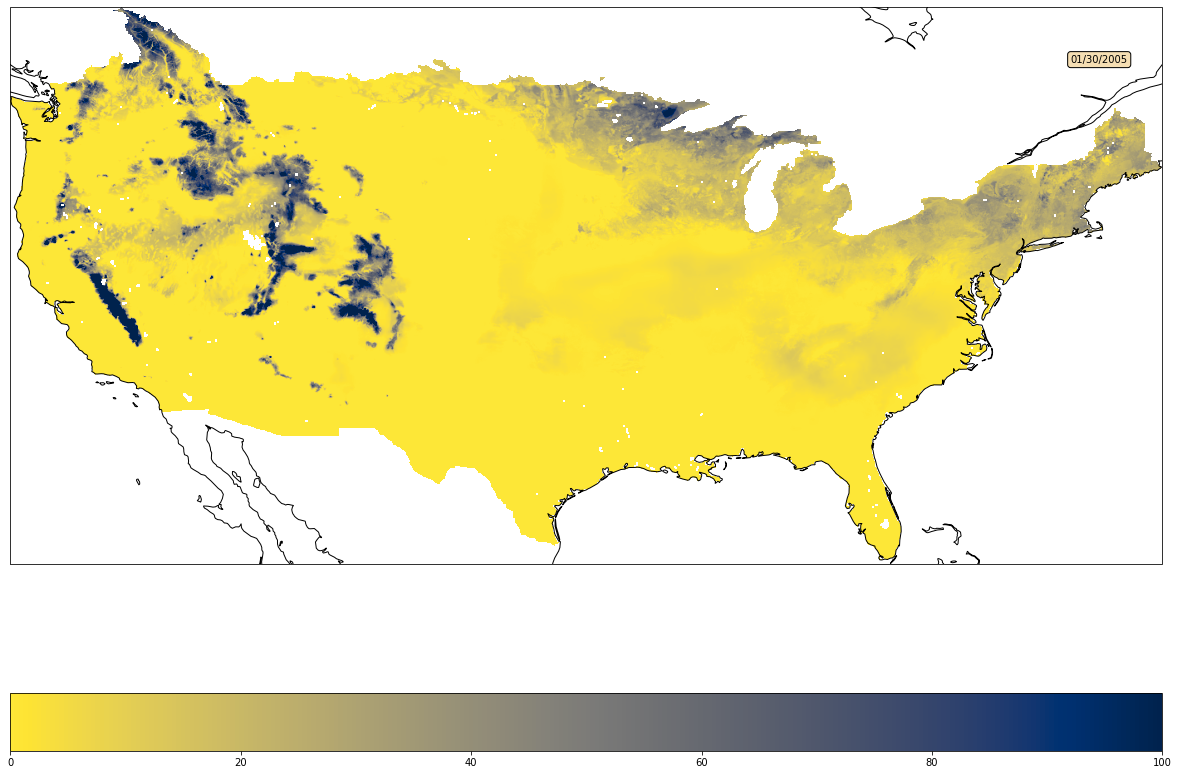

In [8]:
day = datetime.date(2005, 1, 30)
data = data_for_day(day)

%matplotlib inline

fig, ax = plt.subplots(figsize=[6.4*2.5, 4.8*2.5], subplot_kw={"projection": ccrs.PlateCarree()})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

snow_countour = snow_contourf(plt, data)
ax.coastlines()
props = dict(boxstyle='round', facecolor='wheat')
timelabel = ax.text(0.97,0.9, day.strftime('%m/%d/%Y'), transform=ax.transAxes, ha="right", bbox=props)

scale = fig.colorbar(snow_countour, orientation='horizontal')

plt.show()

In [14]:
def animate_day(day):
    global snow_countour, scale, timelabel
    snow_countour.remove()
    data = data_for_day(day)
    snow_countour = snow_contourf(ax, data)

    timelabel.set_text(day.strftime('%m/%d/%Y'))
    return  [snow_countour, timelabel]

In [15]:
ani = animation.FuncAnimation(
    fig,
    animate_day,
    frames=pd.date_range(datetime.date(2004, 1, 1), datetime.date(2014, 1, 1)),
    blit=True,
)

In [16]:
ani.save("snow.mp4", progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'))

Saving frame 0 of 3654
Saving frame 1 of 3654
Saving frame 2 of 3654


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1152x864', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'snow.mp4']' returned non-zero exit status 255.